# Parte 4: Clasificación con Capsnet

La implementación de esta red Capsnet se ha basado en el código implementado por Aurélien Géron (https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb) 

### Resultados con la arquitectura anterior: 

### Cambios realizados

Se aumenta de 100 a 500

### Nuevos resultados: 

### 1 - Import Libraries

In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Signal libraries
from scipy import signal

In [2]:
# Reset the default graph, in case you re-run this notebook without restarting the kernel:
tf.compat.v1.reset_default_graph()

# Random seeds so that this notebook always produces the same output:
np.random.seed(42)
tf.random.set_seed(45)

### 2 - Load data

In [3]:
class ROutput:
    def __init__(self, task, data):
        self.task = task
        self.data = data
        
class OutTaskData: 
    def __init__(self, task, data): 
        self.task = task
        self.data = data

In [4]:
import scipy.io as sio
# Primero leemos los registros
def read_outputs(rec):
    '''read_outputs("userS0091f1.mat")'''
    mat = sio.loadmat(rec)
    mdata = mat['session']
    val = mdata[0,0]
    #output = ROutput(np.array(val["task"]), np.array(val["data"]))
    output = ROutput(np.array(val["task_EEG_p"]), np.array(val["data_processed_EEG"]))
    return output

### Cargamos los datos

In [5]:
# Configuración
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

task1 = 402 # SE PUEDE CAMBIAR
task2 = 404 # SE PUEDE CAMBIAR
task_OneHotEnconding = {402: [1.,0.], 404: [0.,1.]}
user = 'W29' # SE PUEDE CAMBIAR
day = '0329'
folder_day = 'W29-29_03_2021'
total_records = 22 # CAMBIAR SI HAY MAS REGISTROS
fm = 200
electrodes_names_selected = ['F3', 'FZ', 'FC1','FCZ','C1','CZ','CP1','CPZ', 'FC5', 'FC3','C5','C3','CP5','CP3','P3',
                             'PZ','F4','FC2','FC4','FC6','C2','C4','CP2','CP4','C6','CP6','P4','HR' ,'HL', 'VU', 'VD']
number_channels = len(electrodes_names_selected)

In [6]:
lTaskData = []
total_records_used = 0
for i_rec in range(1,total_records+1):
    i_rec_record = i_rec
    if i_rec_record <10:
        i_rec_record = "0"+str(i_rec_record)
    if i_rec % 2 == 0: # Registros impares primero: USUARIO SIN MOVIMIENTO SOLO PENSANDO
        record = "./RegistrosProcesados2/W29_2021"+day+"_openloop_"+str(i_rec_record)+"_processed.mat"
        output = read_outputs(record) # output.task será y, output.data será x


        output.task = np.transpose(output.task)
        output.data = output.data.reshape((np.shape(output.data)[0],np.shape(output.data)[1]))
        output.data = np.transpose(output.data)
        #output.data = output.data.reshape((np.shape(output.data)[0],np.shape(output.data)[1],1))

        outT = (output.task == task1) | (output.task == task2)
        outData = output.data[0:np.shape(output.data)[0], outT[0,:]]
        outTask = output.task[0, outT[0,:]]
        outTD = OutTaskData(outTask, outData)

        lTaskData.append(outTD)
        total_records_used+=1
print(total_records_used, total_records)

11 22


In [7]:
# Vamos a coger 2 registros para el entrenamiento, 1 para el conjunto dev set, 1 para el test set
X_train, y_train, X_dev, y_dev, X_test, y_test = [],[],[],[],[],[] 
for j in range(0,total_records_used-3): # Cogemos 18 registros para entrenamiento
    X_train.append(lTaskData[j].data)
    y_train.append(lTaskData[j].task)

for j in range(total_records_used-3,total_records_used-1): # Cogemos 2 registros para el dev set
    X_dev.append(lTaskData[j].data)
    y_dev.append(lTaskData[j].task)
for j in range(total_records_used-1,total_records_used): # Cogemos 2 registros para el test set
    X_test.append(lTaskData[j].data)
    y_test.append(lTaskData[j].task)

X_train = np.array(X_train)
#y_train = np.ravel(np.array(y_train))
y_train = np.array(y_train)
X_dev = np.array(X_dev)
#y_dev = np.ravel(np.array(y_dev))
y_dev = np.array(y_dev)
X_test = np.array(X_test)
y_test = np.array(y_test)
#y_test = np.ravel(np.array(y_test))

print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)
print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)





# VENTANEO Y ONE HOT ENCODING 
window = 5
samples_advance = 3

# Ventaneo X_train

X_train_l = []
y_train_l = []
for num_X_train in range(np.shape(X_train)[0]): # Para no mezclar registros
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_train)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_train)[2]:
            break

        task = np.unique(y_train[num_X_train,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_train[num_X_train, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_train_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_train_l.append(taskOH)
            #y_train_l.append(task)
            
            
        win_init += int(samples_advance)

X_train_l = np.array(X_train_l)
y_train_l = np.array(y_train_l)


# Ventaneo X_dev
X_dev_l = []
y_dev_l = []
for num_X_dev in range(np.shape(X_dev)[0]):
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_dev)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_dev)[2]:
            break

        task = np.unique(y_dev[num_X_dev,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_dev[num_X_dev, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_dev_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_dev_l.append(taskOH)
            #y_dev_l.append(task)
            
        win_init += int(samples_advance)

X_dev_l = np.array(X_dev_l)
y_dev_l = np.array(y_dev_l)

# Ventaneo X_test
X_test_l = []
y_test_l = []
for num_X_test in range(np.shape(X_test)[0]): 
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_test)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_test)[2]:
            break

        task = np.unique(y_test[num_X_test,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_test[num_X_test, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_test_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            #y_test_l.append(task)
            y_test_l.append(taskOH)
            
        win_init += int(samples_advance)

X_test_l = np.array(X_test_l)
y_test_l = np.array(y_test_l)




X_train_l = X_train_l.reshape((np.shape(X_train_l)[0],np.shape(X_train_l)[1],np.shape(X_train_l)[2], 1))
X_dev_l = X_dev_l.reshape((np.shape(X_dev_l)[0],np.shape(X_dev_l)[1],np.shape(X_dev_l)[2], 1))
X_test_l = X_test_l.reshape((np.shape(X_test_l)[0],np.shape(X_test_l)[1],np.shape(X_test_l)[2], 1))

print()
print("ONE HOT ENCODER & WINDOWING:")
print ("X_train:",X_train_l.shape)
print ("y_train:",y_train_l.shape)
print ("X_dev:",X_dev_l.shape)
print ("y_dev:",y_dev_l.shape)
print ("X_test:",X_test_l.shape)
print ("y_test:",y_test_l.shape)

X_train = X_train_l
y_train = y_train_l
X_dev = X_dev_l
y_dev = y_dev_l
X_test = X_test_l
y_test = y_test_l

X_train = X_train.astype('float32')
X_dev = X_dev.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_dev = y_dev.astype('float32')
y_test = y_test.astype('float32')
print()
print("RESHAPE:")
print ("X_train:",X_train_l.shape)
print ("y_train:",y_train_l.shape)
print ("X_dev:",X_dev_l.shape)
print ("y_dev:",y_dev_l.shape)
print ("X_test:",X_test_l.shape)
print ("y_test:",y_test_l.shape)

X_train: (8, 32, 49)
y_train: (8, 49)
X_dev: (2, 32, 49)
y_dev: (2, 49)
X_test: (1, 32, 49)
y_test: (1, 49)

ONE HOT ENCODER & WINDOWING:
X_train: (104, 32, 5, 1)
y_train: (104, 2)
X_dev: (26, 32, 5, 1)
y_dev: (26, 2)
X_test: (13, 32, 5, 1)
y_test: (13, 2)

RESHAPE:
X_train: (104, 32, 5, 1)
y_train: (104, 2)
X_dev: (26, 32, 5, 1)
y_dev: (26, 2)
X_test: (13, 32, 5, 1)
y_test: (13, 2)


### 4 - Construcción de la Capsnet 

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import csv
import math
import pandas
"""
def plot_log(filename, show=True):

    data = pandas.read_csv(filename)

    fig = plt.figure(figsize=(4,6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    for key in data.keys():
        if key.find('loss') >= 0 and not key.find('val') >= 0:  # training loss
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training loss')

    fig.add_subplot(212)
    for key in data.keys():
        if key.find('acc') >= 0:  # acc
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training and validation accuracy')

    # fig.savefig('result/log.png')
    if show:
        plt.show()


def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

if __name__=="__main__":
    plot_log('result_/sub_dependent_/log_fold.csv')
"""

'\ndef plot_log(filename, show=True):\n\n    data = pandas.read_csv(filename)\n\n    fig = plt.figure(figsize=(4,6))\n    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)\n    fig.add_subplot(211)\n    for key in data.keys():\n        if key.find(\'loss\') >= 0 and not key.find(\'val\') >= 0:  # training loss\n            plt.plot(data[\'epoch\'].values, data[key].values, label=key)\n    plt.legend()\n    plt.title(\'Training loss\')\n\n    fig.add_subplot(212)\n    for key in data.keys():\n        if key.find(\'acc\') >= 0:  # acc\n            plt.plot(data[\'epoch\'].values, data[key].values, label=key)\n    plt.legend()\n    plt.title(\'Training and validation accuracy\')\n\n    # fig.savefig(\'result/log.png\')\n    if show:\n        plt.show()\n\n\ndef combine_images(generated_images, height=None, width=None):\n    num = generated_images.shape[0]\n    if width is None and height is None:\n        width = int(math.sqrt(num))\n        height = int(math.ceil(float(num)/width))\

In [9]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers, regularizers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if isinstance(inputs, list):  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape[0], tuple):  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings,lam_regularize,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.lam_regularize = lam_regularize
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 regularizer=regularizers.l2(self.lam_regularize),
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        #inputs_expand = K.expand_dims(inputs, 1)   SANDRA
        inputs_expand = tf.expand_dims(inputs, 1)
        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        #inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1]) SANDRA
        inputs_tiled  = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1])
        inputs_tiled  = tf.expand_dims(inputs_tiled, 4)
        print("inputs_tiled",np.shape(inputs_tiled))
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        
        #inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled) SANDRA
        inputs_hat = tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled)
        
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        #b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule]) SANDRA
        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.num_capsule, 
                      self.input_num_capsule, 1, 1])
        
        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            #c = tf.nn.softmax(b, dim=1)
            # c =tf.compat.v1.math.softmax(b, axis = 1) SANDRA
            c = layers.Softmax(axis=1)(b)
            print("c",np.shape(c))
            

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            #dot_c = K.batch_dot(c, inputs_hat, [2,2]) sandra
            #print("dot_c",np.shape(dot_c)) sandra

            #outputs = squash(dot_c)  # [None, 10, 16] # sandra
            outputs = tf.multiply(c, inputs_hat)
            outputs = tf.reduce_sum(outputs, axis=2, keepdims=True)
            outputs = squash(outputs, axis=-2)  # [None, 10, 1, 16, 1]
      
            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                # b += K.batch_dot(outputs, inputs_hat, [2, 3]) SANDRA
                outputs_tiled = tf.tile(outputs, [1, 1, self.input_num_capsule, 1, 1])
                agreement = tf.matmul(inputs_hat, outputs_tiled, transpose_a=True)
                b = tf.add(b, agreement)
        # End: Routing algorithm -----------------------------------------------------------------------#
        # Squeeze the outputs to remove useless axis:
        #  From  --> outputs.shape=[None, num_capsule, 1, dim_capsule, 1]
        #  To    --> outputs.shape=[None, num_capsule,    dim_capsule]
        outputs = tf.squeeze(outputs, [2, 4])
        return outputs
    
    """
    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])
    """
    """
    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    """
"""
class channel_attention(layers.Layer):

    def __init__(self, weight_decay=0.00000004, scope="", reuse=None,**kwargs):  #deap H=120,W=24,C=256; dreamer H=123,W=9,C=256
        super(channel_attention, self).__init__(**kwargs)

        self.weight_decay = weight_decay
        self.scope = scope
        self.reuse = reuse

    def build(self,input_shape):
        self.H = input_shape[1]
        self.W = input_shape[2]
        self.C = input_shape[3]
        self.w_c = self.add_weight(name="w_c",
                                   shape=[self.C, self.C],
                                   dtype=tf.float32,
                                   initializer=tf.orthogonal_initializer(),
                                   regularizer=tf.contrib.layers.l1_regularizer(self.weight_decay))

        self.b_c = self.add_weight(name="b_c",
                                   shape=[self.C],
                                   dtype=tf.float32,
                                   initializer=tf.zeros_initializer())
        self.built = True

    def call(self, inputs, training=None):
        feature_map = inputs

        transpose_feature_map = tf.transpose(tf.reduce_mean(feature_map, [1, 2], keep_dims=True),
                                             perm=[0, 3, 1, 2])
        channel_wise_attention_fm = tf.matmul(tf.reshape(transpose_feature_map,
                                                         [-1, self.C]), self.w_c) + self.b_c
        channel_wise_attention_fm = tf.nn.sigmoid(channel_wise_attention_fm)
        #         channel_wise_attention_fm = tf.clip_by_value(tf.nn.relu(channel_wise_attention_fm),
        #                                                      clip_value_min = 0,
        #                                                      clip_value_max = 1)
        attention = tf.reshape(tf.concat([channel_wise_attention_fm] * (self.H * self.W),
                                         axis=1), [-1, self.H, self.W, self.C])
        attended_fm = attention * feature_map
        return attended_fm
"""
"""
class spatial_attention(layers.Layer):

    def __init__(self, weight_decay=0.4, scope="", reuse=None,**kwargs):
        super(spatial_attention, self).__init__(**kwargs)
        self.weight_decay = weight_decay
        self.scope = scope
        self.reuse = reuse

    def build(self,input_shape):
        self.H = input_shape[1]
        self.W = input_shape[2]
        self.C = input_shape[3]
        self.w_s = self.add_weight(name="w_s",
                                   shape=[self.C, 1],
                                   dtype=tf.float32,
                                   initializer=tf.orthogonal_initializer(),
                                   regularizer=tf.contrib.layers.l1_regularizer(self.weight_decay))

        self.b_s = self.add_weight(name="b_s",
                                   shape=[1],
                                   dtype=tf.float32,
                                   initializer=tf.zeros_initializer())
        self.built = True

    def call(self, inputs, training=None):
        feature_map = inputs

        spatial_attention_fm = tf.matmul(tf.reshape(feature_map, [-1, self.C]), self.w_s) + self.b_s
        spatial_attention_fm = tf.nn.sigmoid(tf.reshape(spatial_attention_fm, [-1, self.W * self.H]))
        #         spatial_attention_fm = tf.clip_by_value(tf.nn.relu(tf.reshape(spatial_attention_fm,
        #                                                                       [-1, W * H])),
        #                                                 clip_value_min = 0,
        #                                                 clip_value_max = 1)
        attention = tf.reshape(tf.concat([spatial_attention_fm] * self.C, axis=1), [-1, self.H, self.W, self.C])
        attended_fm = attention * feature_map
        return attended_fm
"""

def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding, lam_regularize):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    outputs = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d',kernel_regularizer= regularizers.l2(lam_regularize))(inputs)
    #if model_version == 'v2':     # MLF-CapsNet
    #    outputs = layers.concatenate([inputs,outputs],axis=3,
    #                                    name='concatenate')

    #   outputs = layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='valid',
    #                          name='bottleneck_layer')(outputs)
    #elif model_version == 'v1':   # MLF-CapsNet without bottleneck layer
    #outputs = layers.concatenate([inputs, outputs], axis=3, name='concatenate')


    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(outputs)#(conca_maps)#(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


"""
# The following is another way to implement primary capsule layer. This is much slower.
# Apply Conv2D `n_channels` times and concatenate all capsules
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    outputs = []
    for _ in range(n_channels):
        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
    outputs = layers.Concatenate(axis=1)(outputs)
    return layers.Lambda(squash)(outputs)
"""
"""
def conca(inputs):
    #[a , b] = inputs
    conca_maps = K.concatenate(inputs, axis=3)
    return conca_maps
"""
"""
def add(inputs):
    [a, b] = inputs
    out = a + b
    return out
"""

'\ndef add(inputs):\n    [a, b] = inputs\n    out = a + b\n    return out\n'

In [10]:
from keras import backend as K
from keras import layers, models, optimizers,regularizers
from keras.layers import InputSpec, Dense
#from capsulelayers import CapsuleLayer, PrimaryCap, Length

K.set_image_data_format('channels_last')

import pandas as pd
import time
import pickle
import numpy as np

"""
def deap_load(data_file,dimention,debaseline):
    rnn_suffix = ".mat_win_128_rnn_dataset.pkl"
    label_suffix = ".mat_win_128_labels.pkl"
    arousal_or_valence = dimention
    with_or_without = debaseline # 'yes','not'
    dataset_dir = "/home/bsipl_5/experiment/ijcnn-master/deap_shuffled_data/" + with_or_without + "_" + arousal_or_valence + "/"

    ###load training set
    with open(dataset_dir + data_file + rnn_suffix, "rb") as fp:
        rnn_datasets = pickle.load(fp)
    with open(dataset_dir + data_file + label_suffix, "rb") as fp:
        labels = pickle.load(fp)
        labels = np.transpose(labels)

    labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)


    # shuffle data
    index = np.array(range(0, len(labels)))
    np.random.shuffle(index)
    rnn_datasets = rnn_datasets[index]  # .transpose(0,2,1)
    labels = labels[index]

    datasets = rnn_datasets.reshape(-1, 128, 32, 1).astype('float32')
    labels = labels.astype('float32')

    return datasets , labels

def dreamer_load(sub,dimention,debaseline):
    if debaseline == 'yes':
        dataset_suffix = "f_dataset.pkl"
        label_suffix = "_labels.pkl"
        dataset_dir = "/home/bsipl_5/experiment/Data/data_pre(-base)/" + dimention + "/"
    else:
        dataset_suffix = "_rnn_dataset.pkl"
        label_suffix = "_labels.pkl"
        dataset_dir = '/home/bsipl_5/experiment/ijcnn-master/dreamer_shuffled_data/' + 'no_' + dimention + '/'

    ###load training set
    with open(dataset_dir + sub + dataset_suffix, "rb") as fp:
        datasets = pickle.load(fp)
    with open(dataset_dir + sub + '_' + dimention + label_suffix, "rb") as fp:
        labels = pickle.load(fp)
        labels = np.transpose(labels)

    labels = labels > 3
    labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)


    # shuffle data
    index = np.array(range(0, len(labels)))
    np.random.shuffle(index)
    datasets = datasets[index]  # .transpose(0,2,1)
    labels = labels[index]

    datasets = datasets.reshape(-1, 128, 14, 1).astype('float32')
    labels = labels.astype('float32')

    return datasets , labels
"""

class CapsToScalars(layers.Layer):

    def __init__(self, **kwargs):
        super(CapsToScalars, self).__init__(**kwargs)
        self.input_spec = InputSpec(min_ndim=3)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

    def call(self, inputs):
        return K.sqrt(K.sum(K.square(inputs + K.epsilon()), axis=-1))

def CapsNet(input_shape, n_class, routings, lam_regularize):
    """
    A Capsule Network .
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer, 对DEAP，kernel_size=9；对DREAMER，kernel_size=6
    conv1 = layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid', activation='relu', name='conv1',kernel_regularizer=regularizers.l2(lam_regularize))(x) #kernel_size=9

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    # 对DEAP，kernel_size=9；对DREAMER，kernel_size=6
    # 对CapsNet，strides=2，pading=‘valid’；对MLF-CapsNet，stides=1，padding='same'
    primarycaps = PrimaryCap(conv1, dim_capsule=4, n_channels=128, kernel_size=3, strides=2, padding='valid',lam_regularize = lam_regularize)
    
    # Layer 3: Capsule layer. Routing algorithm works here.
    micaps = CapsuleLayer(num_capsule=n_class, dim_capsule=8, routings=routings,
                             name='micaps', lam_regularize = lam_regularize)(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(micaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([micaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(micaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=8*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])
    
    return train_model, eval_model
    """
    # manipulate model
    
    noise = layers.Input(shape=(n_class, 8))
    noised_micaps = layers.Add()([micaps, noise])
    masked_noised_y = Mask()([noised_micaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    
    return train_model, eval_model, manipulate_model
    """
    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    """
    out_caps = Length(name='capsnet')(micaps)

    

    # Models for training and evaluation (prediction)
    y = layers.Input(shape=(n_class,))
    train_model = models.Model([x, y], out_caps)
    eval_model = models.Model(x, out_caps)
    """
    #l = K.sqrt(K.sum(K.square(micaps + K.epsilon()), axis=-1))
    

    """
    

    #masked_by_y = Mask_CID()([digits_caps, y])  
    #masked = Mask_CID()(digits_caps)
    
    
    #  Decoder Network
    print("HOLA")
    #model.add(Flatten())
    y = tf.keras.Input(shape=(n_class,))
    masked_by_y = Mask()([micaps, y])  
    masked = Mask()(micaps)
    hidden1 = tf.keras.layers.Dense( 512, activation='relu', name="hidden1") (masked_by_y)
    hidden2 = tf.keras.layers.Dense(1024, activation='relu', name="hidden2") (hidden1)
    decoder_output = tf.keras.layers.Dense(32 * 5, activation='sigmoid', name="decoder_output") (hidden2)
    print("HOLAAAAAAAAa")

    

    train_model = models.Model([x, y], decoder_output)
    eval_model = models.Model(x, decoder_output)
    train_model.summary()
    
    # Decoder Network
    decoder = models.Sequential(name='decoder')
    decoder.add(Dense(512, activation='relu', name="hidden1", output_dim=1024))
    decoder.add(Dense(1024, activation='relu', name="hidden2"))
    decoder.add(Dense(2 * 5, activation='sigmoid', name="decoder_output"))
    
    train_model = models.Model([x, y], [m_capsnet.output, decoder(masked_by_y)])
    eval_model = models.Model(x, [m_capsnet.output, decoder(masked)])
    train_model.summary()
    
    return train_model, eval_model
    """
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (X_train, y_train), (X_dev, y_dev) = data

    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/' + 'log_fold.csv')
    tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs_fold',
                               batch_size=args.batch_size, histogram_freq=args.debug)
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}_fold.h5', monitor='val_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (1.0 ** epoch))

    #EarlyStop = callbacks.EarlyStopping(monitor='val_capsnet_acc', patience=5)
    # compile the model
    model.compile(optimizer= optimizers.Adam(lr=args.lr),
                  loss=margin_loss,
                  loss_weights=[1., args.lam_recon],
                  metrics={'capsnet': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay, EarlyStop])
    """

    '''
    # Training with validation set
    model.fit([x_train, y_train], y_train ,  batch_size=args.batch_size, epochs=args.epochs,verbose = 1,
              validation_split= 0.1 , callbacks=[log, tb, checkpoint, lr_decay])
    '''

    # Training without validation set
    history = model.fit([X_train, y_train],[y_train, X_train], batch_size=args.batch_size, epochs=args.epochs,
                validation_data=([X_dev, y_dev], [y_dev, X_dev]), callbacks=[log, tb, lr_decay])


    #from utils import plot_log
    #plot_log(args.save_dir + '/log.csv', show=True)

    return history

time_start_whole = time.time()


Wed Jun 30 18:58:56 2021
Namespace(batch_size=20, debug=0, epochs=100, gpus=2, lam_recon=0.392, lam_regularize=0.0, lr=1e-05, routings=2, save_dir='./result_/sub_dependent_/', testing=False, weights=None)
inputs_tiled (None, 2, 1792, 4, 1)
c (None, 2, 1792, 1, 1)
c (None, 2, 1792, 1, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 5, 1)]   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 30, 3, 4)     40          input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 14, 1, 512)   18944       conv1[0][0]                      
____

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
inputs_tiled (None, 2, 1792, 4, 1)
c (None, 2, 1792, 1, 1)
c (None, 2, 1792, 1, 1)
inputs_tiled (None, 2, 1792, 4, 1)
c (None, 2, 1792, 1, 1)
c (None, 2, 1792, 1, 1)
6/6 [==============================] - ETA: 0s - loss: 0.8328 - capsnet_loss: 0.8094 - decoder_loss: 0.0596 - capsnet_accuracy: 0.6030inputs_tiled (None, 2, 1792, 4, 1)
c (None, 2, 1792, 1, 1)
c (None, 2, 1792, 1, 1)
6/6 [==============================] - 15s 408ms/step - loss: 0.8329 - capsnet_loss: 0.8094 - decoder_loss: 0.0599 - capsnet_accuracy: 0.6034 - val_loss: 0.8325 - val_capsnet_loss: 0.8094 - val_decoder_loss: 0.0588 - val_capsnet_accuracy: 0.5769
Epoch 2/100
6/6 [==============================] - 0s 42ms/step - loss: 0.8333 - capsnet_loss: 0.8094 - decoder_loss: 0.0610 - capsnet_accuracy: 0.6163 - val_loss: 0.8317 - val_capsnet_loss: 0.8094 - val_decoder_loss: 0.0567 - val_capsnet_accuracy: 0.5769
Epoch 3/100
6/6 [==============================] - 0s 34ms/step - loss: 0.8324 - capsnet_loss: 0.8094 -

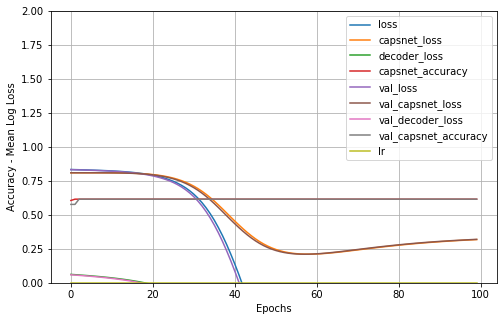

"\nsummary = pd.DataFrame({'fold': range(1,fold+1), 'Test accuracy': test_accuracy_allfold, 'train time': train_used_time_allfold, 'test time': test_used_time_allfold})\nhyperparam = pd.DataFrame({'average acc of 10 folds': np.mean(test_accuracy_allfold), 'average train time of 10 folds': np.mean(train_used_time_allfold), 'average test time of 10 folds': np.mean(test_used_time_allfold),'epochs': args.epochs, 'lr':args.lr, 'batch size': args.batch_size},index=['dimention/sub'])\nwriter = pd.ExcelWriter(args.save_dir + '/'+'summary'+ '_'+subject+'.xlsx')\nsummary.to_excel(writer, 'Result', index=False)\nhyperparam.to_excel(writer, 'HyperParam', index=False)\nwriter.save()\nprint('10 fold average accuracy: ', np.mean(test_accuracy_allfold))\nprint('10 fold average train time: ', np.mean(train_used_time_allfold))\nprint('10 fold average test time: ', np.mean(test_used_time_allfold))\n"

In [11]:
import numpy as np
import tensorflow as tf
import os
from keras import callbacks
from keras.utils.vis_utils import plot_model
#from keras.utils import multi_gpu_model

# setting the hyper parameters
import argparse

parser = argparse.ArgumentParser(description="Capsule Network on " + folder_day)
parser.add_argument('--epochs', default=100, type=int)  
parser.add_argument('--batch_size', default=20, type=int)
parser.add_argument('--lam_regularize', default=0.0, type=float,
                    help="The coefficient for the regularizers")
parser.add_argument('--lam_recon', default=0.392, type=float,
                        help="The coefficient for the loss of decoder")
parser.add_argument('-r', '--routings', default=2, type=int,
                    help="Number of iterations used in routing algorithm. should > 0")
parser.add_argument('--debug', default=0, type=int,
                    help="Save weights by TensorBoard")
parser.add_argument('--save_dir', default='./result_/sub_dependent_/') # other
parser.add_argument('-t', '--testing', action='store_true',
                    help="Test the trained model on testing dataset")
parser.add_argument('-w', '--weights', default=None,
                    help="The path of the saved weights. Should be specified when testing")
parser.add_argument('--lr', default=0.00001, type=float,
                    help="Initial learning rate")  # v0:0.0001, v2:0.00001

parser.add_argument('--gpus', default=2, type=int)

#args = parser.parse_args()
args, unknown = parser.parse_known_args()


print(time.asctime(time.localtime(time.time())))
print(args)
if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

#if dataset_name == 'dreamer':          # load dreamer data
#    datasets,labels = dreamer_load(subject,dimention,debaseline)
#else:  # load deap data
#    datasets,labels = deap_load(subject,dimention,debaseline)

args.save_dir = args.save_dir
if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

#fold = 10
#test_accuracy_allfold = np.zeros(shape=[0], dtype=float)
#train_used_time_allfold = np.zeros(shape=[0], dtype=float)
#test_used_time_allfold = np.zeros(shape=[0], dtype=float)
#for curr_fold in range(fold):
#fold_size = datasets.shape[0] // fold
#indexes_list = [i for i in range(len(datasets))]
#indexes = np.array(indexes_list)
#split_list = [i for i in range(curr_fold * fold_size, (curr_fold + 1) * fold_size)]
#split = np.array(split_list)
#x_test = datasets[split]
#y_test = labels[split]

#split = np.array(list(set(indexes_list) ^ set(split_list)))
#x_train = datasets[split]
#y_train = labels[split]

#train_sample = y_train.shape[0]
#print("training examples:", train_sample)
#test_sample = y_test.shape[0]
#print("test examples    :", test_sample)

# define model

with tf.device('/cpu:0'):
    model, eval_model = CapsNet(input_shape=X_train.shape[1:],
                                                  n_class=len(np.unique(y_train)),
                                                  routings=args.routings,
                                                  lam_regularize = args.lam_regularize)

model.summary()
plot_model(model, to_file=args.save_dir+'/model_fold.png', show_shapes=True)


# train
train_start_time = time.time()
history = train(model, data=((X_train, y_train), (X_dev, y_dev)), args=args)
train_used_time = time.time() - train_start_time

results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

In [12]:
history.params

{'epochs': 100, 'steps': 6, 'verbose': 1}

In [13]:
results[-1:]

,loss,capsnet_loss,decoder_loss,capsnet_accuracy,val_loss,val_capsnet_loss,val_decoder_loss,val_capsnet_accuracy,lr
99,-6.870526,0.318049,-18.3382,0.615385,-6.930588,0.319699,-18.495632,0.615385,0.00001


In [14]:
print ("Accuracy for the training set: ", results.values[-1:][0][1])

Accuracy for the training set:  0.31804943084716797


In [15]:
print ("Accuracy for the development test set: ", results.values[-1:][0][3])

Accuracy for the development test set:  0.6153846383094788
